In [ ]:
!nvidia-smi

Mon Jul 18 16:19:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install pretrainedmodels
!pip install efficientnet_pytorch
!pip install timm

In [ ]:
!pip install opencv-python-headless==4.1.2.30

In [ ]:
!pip install PyYAML==5.3.1

In [ ]:
!pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.1.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.8
bokeh                         2.3.3
branca                        0.5.0
bs4                           0.0.1
CacheControl                  0.1

In [ ]:
!git clone https://github.com/qubvel/segmentation_models.pytorch

Cloning into 'segmentation_models.pytorch'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 6.04 MiB | 18.41 MiB/s, done.
Resolving deltas: 100% (918/918), done.


In [ ]:
%cd /content/segmentation_models.pytorch

/content/segmentation_models.pytorch


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive #インポート
drive.mount('/content/gdrive') #GoogleDriveのマウント

Mounted at /content/gdrive


In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val') 
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
print('the number of image/label in the train: ',len(os.listdir(x_train_dir)))
print('the number of image/label in the validation: ',len(os.listdir(x_valid_dir)))
print('the number of image/label in the test: ',len(os.listdir(x_test_dir)))

the number of image/label in the train:  367
the number of image/label in the validation:  101
the number of image/label in the test:  233


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# segモデルの推論

In [ ]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'

[<PIL.Image.Image image mode=RGB size=928x608 at 0x7F8ED49B1A90>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F8ED4592A90>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F8ED41E0110>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F8ED5D1E5D0>]


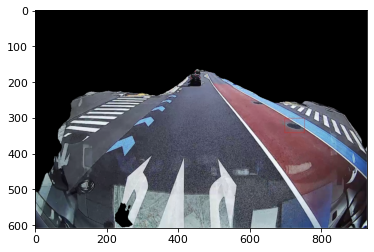

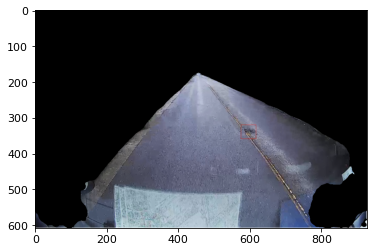

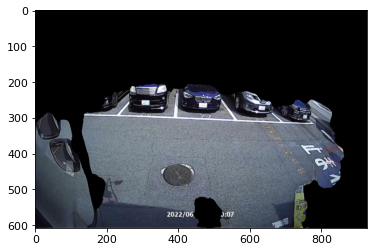

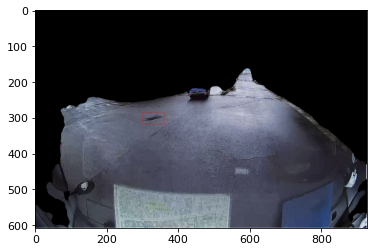

In [ ]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'

def imgpil_to_npimage(image_pil):
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]
  # [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]で正規化するよ〜
  image = image/256
  image =  image - np.array([0.485, 0.456, 0.406])
  image = image/np.array([0.229, 0.224, 0.225])
  image = image.transpose((2,0,1))
  return image

img_paths = ["/content/1.png", "/content/2.png", "/content/3.png", "/content/4.png"]
img_pils = []
for img_path in img_paths:
    img_pils.append(Image.open(img_path))


img_list = np.array(list(map(imgpil_to_npimage, img_pils)))
x_tensor = torch.from_numpy(img_list).to(DEVICE).float()
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

to_yolo_imagePIL = []
for enunum, mask_im in enumerate(pr_mask):
  mask_im = mask_im.transpose((1, 2, 0))
  # mask_imを白黒画像にする。
  for i in range(3):
    mask_im[:, :, i] = mask_im[:, :, 1]

  image_pil = img_pils[enunum]
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]

  view_image = image*mask_im
  view_image = Image.fromarray(view_image.astype(np.uint8))
  to_yolo_imagePIL.append(view_image)
  plt.figure()
  plt.imshow(view_image)
  plt.show()

print(to_yolo_imagePIL)

APIに代替するコードはここから

In [240]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
# modelは、setting.py変数化
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'
img_paths = ["/content/1.png", "/content/2.png", "/content/3.png", "/content/4.png"]
img_pils = []
for img_path in img_paths:
    img_pils.append(Image.open(img_path))


def imgpil_to_npimage(image_pil):
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]
  # [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]で正規化するよ〜
  image = image/256
  image =  image - np.array([0.485, 0.456, 0.406])
  image = image/np.array([0.229, 0.224, 0.225])
  image = image.transpose((2,0,1))
  return image
# 75行目から83行目のinput_listをimg_pilsに変更するとそのまま運用可能

img_list = np.array(list(map(imgpil_to_npimage, img_pils)))
x_tensor = torch.from_numpy(img_list).to(DEVICE).float()
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

to_yolo_imagePIL = []
for enunum, mask_im in enumerate(pr_mask):
  mask_im = mask_im.transpose((1, 2, 0))
  # mask_imを白黒画像にする。
  for i in range(3):
    mask_im[:, :, i] = mask_im[:, :, 1]

  image_pil = img_pils[enunum]
  transform = transforms.Resize((608, 928))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]

  view_image = image*mask_im
  view_image = Image.fromarray(view_image.astype(np.uint8))
  to_yolo_imagePIL.append(view_image)
print(to_yolo_imagePIL)

[<PIL.Image.Image image mode=RGB size=928x608 at 0x7F8D67E58E90>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F8ED493FA10>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F8ED493F4D0>, <PIL.Image.Image image mode=RGB size=928x608 at 0x7F8ED493FE90>]


In [241]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# YOLO_MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path='/code/static/model/asahuka96hozon.pt')
YOLO_MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/holeplus.pt')
YOLO_MODEL.to(device)
YOLO_MODEL.conf = 0.25  # NMS confidence threshold
YOLO_MODEL.iou = 0.45  # NMS IoU threshold
YOLO_MODEL.agnostic = False  # NMS class-agnostic
YOLO_MODEL.multi_label = False  # NMS multiple labels per box
YOLO_MODEL.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
YOLO_MODEL.max_det = 1000  # maximum number of detections per image
YOLO_MODEL.amp = False  # Automatic Mixed Precision (AMP) inference
model = YOLO_MODEL
print("YOLOv5 🚀 torch 1.10.2+cu102")
input_list = to_yolo_imagePIL

results = model(input_list, size=640)
num = len(input_list)
out_result = {}
out_result["output_"] = []
for k in range(num):
    result = results.pandas().xyxy[k]
    result = result[result["class"]==0]
    out_result["output_"].append(result.to_json(orient="records"))

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-7-18 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

YOLOv5 🚀 2022-7-18 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

Fusing layers... 
Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients
Model summary: 213 layers, 7018216 parameters, 0 gradients
Adding AutoShape... 
Adding AutoShape... 


YOLOv5 🚀 torch 1.10.2+cu102


In [242]:
out_result["output_"]

['[]',
 '[{"xmin":570.1845703125,"ymin":320.2659301758,"xmax":622.3637695312,"ymax":358.7599182129,"confidence":0.831471622,"class":0,"name":"hole"}]',
 '[]',
 '[]']

0
1
2
3


<Figure size 432x288 with 0 Axes>

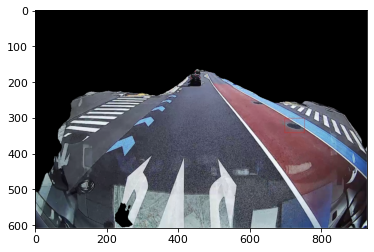

<Figure size 432x288 with 0 Axes>

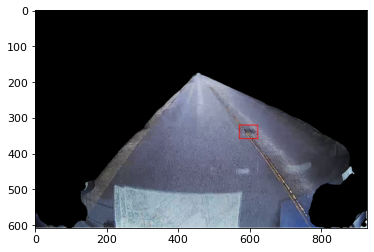

<Figure size 432x288 with 0 Axes>

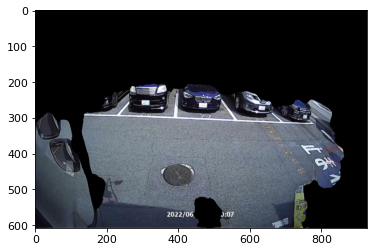

<Figure size 432x288 with 0 Axes>

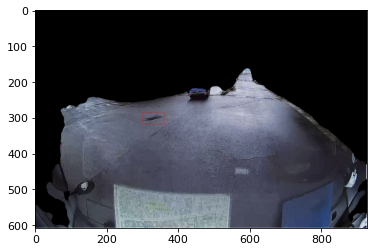

In [243]:
import ast
for enunum, _ in enumerate(out_result["output_"]):
  print(enunum)
  img_pil = to_yolo_imagePIL[enunum]
  for bbox in ast.literal_eval(_):
    draw = ImageDraw.Draw(img_pil)
    # pillowの四角形表示は、枠線を調節する変数はない。
    draw.rectangle((bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]), fill=None, outline=(255, 0, 0))
    draw.rectangle((bbox["xmin"]+1, bbox["ymin"]+1, bbox["xmax"]+1, bbox["ymax"]+1), fill=None, outline=(255, 0, 0))
  plt.figure()
  plt.figure()
  plt.imshow(img_pil)
  plt.show()

# 未知物体検出モデル

In [251]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'

In [252]:
from PIL import Image, ImageFont, ImageDraw
from torchvision import transforms
import torch
# modelは、setting.py変数化
best_model = torch.load('/content/best_model_quita_600.pth')
DEVICE = 'cuda'
img_paths = ["/content/toOOD1.jpg", "/content/toOOD2.jpg", "/content/toOOD3.jpg"]
img_pils = []
for img_path in img_paths:
    img_pils.append(Image.open(img_path))


def imgpil_to_npimage(image_pil):
  transform = transforms.Resize((32*20, 32*29))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]
  # [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]で正規化するよ〜
  image = image/256
  image =  image - np.array([0.485, 0.456, 0.406])
  image = image/np.array([0.229, 0.224, 0.225])
  image = image.transpose((2,0,1))
  return image
# 75行目から83行目のinput_listをimg_pilsに変更するとそのまま運用可能

img_list = np.array(list(map(imgpil_to_npimage, img_pils)))
x_tensor = torch.from_numpy(img_list).to(DEVICE).float()
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

to_yolo_imagePIL = []
for enunum, mask_im in enumerate(pr_mask):
  mask_im = mask_im.transpose((1, 2, 0))
  # mask_imを白黒画像にする。
  for i in range(3):
    mask_im[:, :, i] = mask_im[:, :, 1]

  image_pil = img_pils[enunum]
  transform = transforms.Resize((32*20, 32*29))
  image = transform(image_pil)
  image = np.array(image)
  # 色チャネルが4で出力されるため, 最初の3のみ使用する。
  if len(image[0]) != 3:
    image = image[:,:,:3]

  view_image = image*mask_im
  view_image = Image.fromarray(view_image.astype(np.uint8))
  to_yolo_imagePIL.append(view_image)
print(to_yolo_imagePIL)

[<PIL.Image.Image image mode=RGB size=928x640 at 0x7F8ED41CD950>, <PIL.Image.Image image mode=RGB size=928x640 at 0x7F8E6C0BE350>, <PIL.Image.Image image mode=RGB size=928x640 at 0x7F8D69AF8BD0>]


In [253]:
# !git clone https://github.com/ultralytics/yolov5.git

In [254]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# YOLO_MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path='/code/static/model/asahuka96hozon.pt')
YOLO_MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/OOD_v1_100clust.pt')
YOLO_MODEL.to(device)
YOLO_MODEL.conf = 0.1  # NMS confidence threshold
YOLO_MODEL.iou = 0.1  # NMS IoU threshold
YOLO_MODEL.agnostic = True  # NMS class-agnostic
YOLO_MODEL.multi_label = False  # NMS multiple labels per box
YOLO_MODEL.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
YOLO_MODEL.max_det = 1000  # maximum number of detections per image
YOLO_MODEL.amp = False  # Automatic Mixed Precision (AMP) inference
# YOLO_MODEL.single_cls = True
# YOLO_MODEL.agnostic_nms = True

model = YOLO_MODEL
print("YOLOv5 🚀 torch 1.10.2+cu102")
input_list = to_yolo_imagePIL

results = model(input_list, size=640*2)
num = len(input_list)
out_result = {}
out_result["output_"] = []
for k in range(num):
    result = results.pandas().xyxy[k]
    result["class"]=0
    result["name"]="object"
    # result = result[result["class"]==0]
    out_result["output_"].append(result.to_json(orient="records"))

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-7-18 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

YOLOv5 🚀 2022-7-18 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

Fusing layers... 
Fusing layers... 
Model summary: 213 layers, 7279825 parameters, 0 gradients
Model summary: 213 layers, 7279825 parameters, 0 gradients
Adding AutoShape... 
Adding AutoShape... 


YOLOv5 🚀 torch 1.10.2+cu102


In [255]:
out_result["output_"]

['[{"xmin":468.1511230469,"ymin":0.0418440215,"xmax":928.0,"ymax":433.5813903809,"confidence":0.1013211459,"class":0,"name":"object"}]',
 '[{"xmin":596.7298583984,"ymin":484.508972168,"xmax":772.2283325195,"ymax":588.3393554688,"confidence":0.3362677991,"class":0,"name":"object"},{"xmin":192.5428924561,"ymin":467.8258361816,"xmax":394.6825561523,"ymax":567.7704467773,"confidence":0.1112284288,"class":0,"name":"object"}]',
 '[{"xmin":156.7176513672,"ymin":489.4753723145,"xmax":441.7762451172,"ymax":578.7926025391,"confidence":0.5685682297,"class":0,"name":"object"}]']

0
1
2


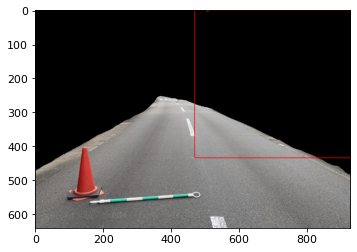

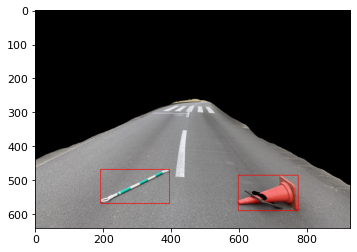

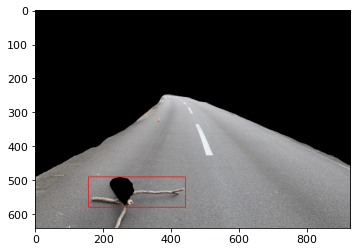

In [256]:
import ast
for enunum, _ in enumerate(out_result["output_"]):
  print(enunum)
  img_pil = to_yolo_imagePIL[enunum]
  for bbox in ast.literal_eval(_):
    draw = ImageDraw.Draw(img_pil)
    draw.rectangle((bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]), fill=None, outline=(255, 0, 0))
    draw.rectangle((bbox["xmin"]+1, bbox["ymin"]+1, bbox["xmax"]+1, bbox["ymax"]+1), fill=None, outline=(255, 0, 0))
  plt.figure()
  plt.imshow(img_pil)
  plt.show()